# Lumin-human project geohackweek 2019
## Initial script to extract survey data based on the following study:
### Jean et al. Combining satellite imagery and machine learning to predict poverty. Science 19 Aug 2016: Vol. 353, Issue 6301, pp. 790-794. DOI: 10.1126/science.aaf7894 
#### Accompanying code from the paper is published here: https://github.com/nealjean/predicting-poverty


In this notebook, only parts of what they did in that paper is done: only one type of Survey data is used (LSMS) for one country (Tanzania 2012-13). The survey data needs to be downloaded separately, the link posted by the authors is no longer active, this is the link used for this notebook: https://microdata.worldbank.org/index.php/catalog/2252

Team members:

Lee Mackey,
Jimmy Feng,
Yohan Min,
Sumithra Velupillai

This notebook written by: sumithra

In [1]:
import pandas as pd
import numpy as np
import geopandas as gpd
import shapely
import matplotlib.pyplot as plt

### Copy of R code from the scripts provided by Jean et al.  (for reference only)
### re: reading LSMS data for Tanzania 2012:

This is only for Tanzania - they do different things for other country data
 Tanzania 
```R
tza13.cons <- read.dta('data/input/LSMS/TZA_2012_LSMS_v01_M_STATA_English_labels/ConsumptionNPS3.dta') %$%
  data.frame(hhid = y3_hhid, cons = expmR/(365*adulteq))
tza13.cons$cons <- tza13.cons$cons*112.69/(585.52*mean(c(130.72,141.01)))
tza13.geo <- read.dta13('data/input/LSMS/TZA_2012_LSMS_v01_M_STATA_English_labels/HouseholdGeovars_Y3.dta')
tza13.coords <- data.frame(hhid = tza13.geo$y3_hhid, lat = tza13.geo$lat_dd_mod, lon = tza13.geo$lon_dd_mod)
tza13.hha <- read.dta('data/input/LSMS/TZA_2012_LSMS_v01_M_STATA_English_labels/HH_SEC_A.dta')
tza13.rururb <- data.frame(hhid = tza13.hha$y3_hhid, rururb = tza13.hha$y3_rural, stringsAsFactors = F)
tza13.weight <- read.dta('data/input/LSMS/TZA_2012_LSMS_v01_M_STATA_English_labels/HH_SEC_A.dta')[,c('y3_hhid', 'y3_weight')]
names(tza13.weight) <- c('hhid', 'weight')
tza13.hhi <- read.dta('data/input/LSMS/TZA_2012_LSMS_v01_M_STATA_English_labels/HH_SEC_I.dta')
tza13.room <- na.omit(data.frame(hhid = tza13.hhi$y3_hhid, room = tza13.hhi$hh_i07_1))
tza13.metal <- data.frame(hhid = tza13.hhi$y3_hhid, metal = tza13.hhi$hh_i09=='METAL SHEETS (GCI)')

tza13.vars <- list(tza13.cons, tza13.coords, tza13.rururb, tza13.weight, tza13.room, tza13.metal) %>%
  Reduce(function(x, y) merge(x, y, by = 'hhid'), .) %>%
  nl(2013)

write.table(tza13.vars, 'data/output/LSMS/Tanzania 2013 LSMS (Household).txt', row.names = F)
write.table(cluster(tza13.vars), 'data/output/LSMS/Tanzania 2013 LSMS (Cluster).txt', row.names = F
```

The script from the authors point to a link that is no longer active, the currently available data at https://microdata.worldbank.org/index.php/catalog/2252 is slightly different, but similar data is contained

#### First step: data from the collections of files provided in the LSMS survey to save for this work: 

consumption: ConsumptionNPS3.csv, Householdgeovars: HouseholdGeovars_Y3.csv, HH_SEC_A: HH_SEC_A.csv, HH_SEC_I: HH_SEC_I.csv

1: Just to explore - all columns contained in ConsumptionNPS3.csv
Columns: "y3_hhid","foodbev","alctob","foodIN","foodOUT","utilities","hhexpenses","health","transport","communic","recreat","educa","other","expm","fisherb3c3","foodbevR","alctobR","foodINR","foodOUTR","utilitiesR","hhexpensesR","healthR","transportR","communicR","recreatR","educaR","otherR","expmR","hhsize","expmR","urban","region","area","mainland","quarter"

In [2]:
## To keep: y3_hhid, expmR, adulteq

In [3]:
# Reading in the data into the variable consumption - NOTE path needs to be changed!
consumption = pd.read_csv('/Users/sumithra/DSV/MeDESTO/geohackweek2019/TZA_2012_NPS-R3_v01_M_CSV/ConsumptionNPS3.csv')

In [4]:
## Just a look at what's in there:
consumption.head()

,y3_hhid,foodbev,alctob,foodIN,foodOUT,utilities,hhexpenses,health,transport,communic,...,educaR,otherR,expmR,hhsize,adulteq,urban,region,area,mainland,quarter
0,0001-001,878800.0,0.0,878800.0,0,59200,123200,656500,0,120000,...,0.000000,27853.652344,1.966742e+06,4,3.60,1,1,3,1,1
1,0002-001,475800.0,0.0,444600.0,31200,31800,3600,0,0,0,...,0.000000,24266.439453,5.636144e+05,4,2.84,1,1,3,1,1
2,0003-001,3536000.0,93600.0,3265600.0,364000,257200,180000,0,336000,180000,...,214177.703125,430465.531250,5.479784e+06,6,5.28,1,1,3,1,1
3,0003-010,3445000.0,0.0,2472600.0,972400,602000,268000,303000,322400,300000,...,0.000000,193136.468750,4.906560e+06,4,3.24,2,7,1,1,1
4,0005-001,2522375.5,0.0,2418375.5,104000,96600,102800,67600,300000,57600,...,9495.563477,107616.382812,3.437368e+06,5,3.60,1,1,3,1,1


In [5]:
## We want to only save a few columns, passing these into the variable df
df = consumption[['y3_hhid', 'expmR', 'adulteq']]

In [6]:
## Function based on what they did in their script - average yearly consumption (?)
def to_cons(row):
    return row['expmR']/365*row['adulteq']
    

In [7]:
## Just a quick look at the new dataframe
df.head()

,y3_hhid,expmR,adulteq
0,0001-001,1.966742e+06,3.60
1,0002-001,5.636144e+05,2.84
2,0003-001,5.479784e+06,5.28
3,0003-010,4.906560e+06,3.24
4,0005-001,3.437368e+06,3.60


In [8]:
## Applying the function 'to_cons' and saving in a new column 'cons'
df['cons'] = df.apply(to_cons, axis=1)

/Users/sumithra/.local/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [9]:
## Second calculation from the provided script - this probably relates to normalising currency (?)
def calc_converted_values(row):
    return row*112.69/(585.52*np.mean([130.72,141.01]))

In [10]:
## Applying the function and saving in a new column value 'cons2'
df['cons2'] = df['cons'].apply(calc_converted_values)

/Users/sumithra/.local/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [11]:
## Now we have these two new columns in our dataframe
df.head()

,y3_hhid,expmR,adulteq,cons,cons2
0,0001-001,1.966742e+06,3.60,19398.004649,27.478506
1,0002-001,5.636144e+05,2.84,4385.383574,6.212174
2,0003-001,5.479784e+06,5.28,79269.204630,112.289863
3,0003-010,4.906560e+06,3.24,43554.125810,61.697186
4,0005-001,3.437368e+06,3.60,33902.807615,48.025480


In [12]:
## Next step is to load the geo variables from the survey data
#tza13.geo <- read.dta13('data/input/LSMS/TZA_2012_LSMS_v01_M_STATA_English_labels/HouseholdGeovars_Y3.dta')

## PATH NEEDS TO BE CHANGED
geo = pd.read_csv('/Users/sumithra/DSV/MeDESTO/geohackweek2019/TZA_2012_NPS-R3_v01_M_CSV/HouseholdGeovars_Y3.csv')

In [13]:
## We only need to save id, latitude and longitude values
dfgeo = geo[['y3_hhid', 'lat_dd_mod', 'lon_dd_mod']]

In [14]:
## Quick look at the dataframe with geo variables (dfgeo)
dfgeo.head()

,y3_hhid,lat_dd_mod,lon_dd_mod
0,0001-001,-5.085751,35.854389
1,0002-001,-5.085751,35.854389
2,0003-001,-5.085751,35.854389
3,0003-010,-6.860888,39.251984
4,0005-001,-5.085751,35.854389


In [15]:
## Let's now merge the two dataframes so that we can get geo locations for the consumption values 
# - saving in a new dataframe: df_merged
df_merged = pd.merge(df, dfgeo, on='y3_hhid')

In [16]:
## How many individual values do we have?
len(df_merged)

4862

In [17]:
df_merged.head()

,y3_hhid,expmR,adulteq,cons,cons2,lat_dd_mod,lon_dd_mod
0,0001-001,1.966742e+06,3.60,19398.004649,27.478506,-5.085751,35.854389
1,0002-001,5.636144e+05,2.84,4385.383574,6.212174,-5.085751,35.854389
2,0003-001,5.479784e+06,5.28,79269.204630,112.289863,-5.085751,35.854389
3,0003-010,4.906560e+06,3.24,43554.125810,61.697186,-6.860888,39.251984
4,0005-001,3.437368e+06,3.60,33902.807615,48.025480,-5.085751,35.854389


#### In the paper, they cluster household/consumption values to 
##### Cluster function from the paper - for reference only

```R
# Aggregate household-level data to cluster level
cluster <- function(df, dhs = F){
  # Record how many households comprise each cluster
  for (i in 1:nrow(df)){
    sub <- subset(df, lat == df$lat[i] & lon == df$lon[i])
    df$n[i] <- nrow(sub)
  }
  # Clustering for LSMS survey data
  df <- if (dhs == FALSE)
    ddply(df, .(lat, lon), summarise,
          cons = mean(cons),
          nl = mean(nl),
          n = mean(n),
          sample = min(sample))
  # Clustering for DHS survey data
  else ddply(df, .(lat, lon), summarise,
             wealthscore = mean(wealthscore),
             nl = mean(nl),
             n = mean(n),
             sample = min(sample))
  return(df)
}
```

In [18]:
## Replication of clustering:
## THIS IS NO LONGER USED

## First filter out any rows where the latitude + longitude only occurs once (i.e. only one household):
#filtered = df_merged.groupby(['lat_dd_mod', 'lon_dd_mod']).filter(lambda x: len(x) > 1)

## Then calculate the mean cons2 for each cluster of lat+lon households
#tmp = filtered.groupby(['lat_dd_mod', 'lon_dd_mod'])['cons2'].mean()
#tmp.columns=['lat_dd_mod', 'lon_dd_mod', 'cons2']




In [19]:
## Workaround to get the clusters in the below cells - this could be done better!

In [20]:
## First: get the counts
tmp2 = pd.DataFrame({'count' : df_merged.groupby( [ 'lat_dd_mod', 'lon_dd_mod'] ).size()}).reset_index()
tmp2 = tmp2.rename_axis('id')
tmp2 = tmp2.rename_axis('id').rename_axis('hhid', axis='columns')
tmp2

hhid,lat_dd_mod,lon_dd_mod,count
id,,,
0,-11.497012,35.607626,13
1,-11.366755,35.022468,1
2,-11.315454,34.786297,9
3,-11.267840,34.788405,1
4,-11.240451,38.332099,1
...,...,...,...
1519,-1.174007,31.649949,1
1520,-1.126321,33.980574,1
1521,-1.079315,31.407303,1


In [21]:
## Then get the mean values for 'cons2' for each cluster
tmp3 = pd.DataFrame({'cons2' : df_merged.groupby( [ 'lat_dd_mod', 'lon_dd_mod'] )['cons2'].mean()}).reset_index()
tmp3 = tmp3.rename_axis('id')
tmp3 = tmp3.rename_axis('id').rename_axis('hhid', axis='columns')
tmp3

hhid,lat_dd_mod,lon_dd_mod,cons2
id,,,
0,-11.497012,35.607626,42.264669
1,-11.366755,35.022468,21.560781
2,-11.315454,34.786297,33.312532
3,-11.267840,34.788405,11.209021
4,-11.240451,38.332099,31.982783
...,...,...,...
1519,-1.174007,31.649949,31.866544
1520,-1.126321,33.980574,20.961494
1521,-1.079315,31.407303,11.426310


In [22]:
## merge these together and keep only those with a count larger than 1 household
cluster_df = pd.merge(tmp2, tmp3, on='id')
cluster_df = cluster_df[cluster_df['count']>1]
cluster_df

hhid,lat_dd_mod_x,lon_dd_mod_x,count,lat_dd_mod_y,lon_dd_mod_y,cons2
id,,,,,,
0,-11.497012,35.607626,13,-11.497012,35.607626,42.264669
2,-11.315454,34.786297,9,-11.315454,34.786297,33.312532
6,-11.170319,34.996472,12,-11.170319,34.996472,23.262399
10,-11.108790,34.642166,9,-11.108790,34.642166,48.164958
12,-11.072451,37.319251,11,-11.072451,37.319251,24.731698
...,...,...,...,...,...,...
1505,-1.335650,31.822935,10,-1.335650,31.822935,88.142518
1507,-1.324776,34.354972,14,-1.324776,34.354972,151.964764
1516,-1.213422,31.665497,10,-1.213422,31.665497,68.447434


### Some initial experiments in plotting these points on a map - to be continued

Questions:
- Why are the points slightly off on the map?
- Other shape files - adding city tags, etc?

In [23]:
## Converting lat+lon to points
geometry = [shapely.geometry.Point(xy) for xy in zip(df_merged['lon_dd_mod'], df_merged['lat_dd_mod'])]

In [24]:
## creating a geopandas dataframe with the points on all the data (i.e. no clusters)
geo_df = gpd.GeoDataFrame(df_merged, geometry=geometry)
geo_df.crs = {'init' :'epsg:4326'}

In [25]:
geo_df.describe()

,expmR,adulteq,cons,cons2,lat_dd_mod,lon_dd_mod
count,4.862000e+03,4862.000000,4.862000e+03,4862.000000,4862.000000,4862.000000
mean,4.087372e+06,4.140000,5.764781e+04,81.661779,-6.124882,36.321637
std,3.729201e+06,2.550232,1.034273e+05,146.511329,2.596510,3.069027
min,1.375010e+05,0.720000,3.315093e+02,0.469604,-11.497012,29.611354
25%,1.830167e+06,2.280000,1.332598e+04,18.877096,-7.640233,33.490770
50%,3.049115e+06,3.640000,2.914665e+04,41.288077,-6.167528,37.135584
75%,4.922050e+06,5.440000,6.514883e+04,92.287463,-4.065404,39.232132
max,4.655255e+07,39.800000,3.457857e+06,4898.274278,-0.998074,40.421223


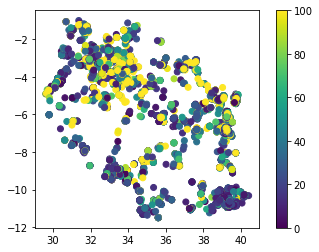

In [26]:
## First, a simple plot with the full dataset. vmin and vmax are set based on the distribution in the above cell for cons2
fig, ax = plt.subplots(1, 1)
geo_df.plot(column='cons2', ax=ax, legend=True, vmin=0, vmax=100);

In [27]:
## Same thing with the filtered data
geometry_filtered = [shapely.geometry.Point(xy) for xy in zip(cluster_df['lon_dd_mod_x'], cluster_df['lat_dd_mod_x'])]

In [28]:
geo_df_filtered = gpd.GeoDataFrame(cluster_df, geometry=geometry_filtered)
geo_df_filtered.crs = {'init' :'epsg:4326'}

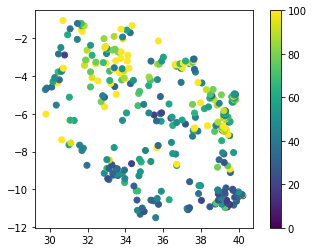

In [29]:
fig, ax = plt.subplots(1, 1)
geo_df_filtered.plot(column='cons2', ax=ax, legend=True, figsize=(10, 10), vmin=0, vmax=100);

In [30]:
## Reading in world map from tutorial material
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
## Keeping only Tanzania
tan = world[world['name']=='Tanzania']


In [31]:
tan.crs

{'init': 'epsg:4326'}

In [32]:
## From tutorial material - not used with the current data
#import requests
#import geojson

#wfs_url = "http://data.nanoos.org/geoserver/ows"
#params = dict(service='WFS', version='1.0.0', request='GetFeature',
#              typeName='oa:goaoninv', outputFormat='json')

#r = requests.get(wfs_url, params=params)
#wfs_geo = geojson.loads(r.content)

In [33]:
#print(type(wfs_geo))
#print(wfs_geo.keys())
#print(len(wfs_geo.__geo_interface__['features']))

In [34]:
##wfs_gdf = gpd.GeoDataFrame.from_features(wfs_geo)
## add boundary

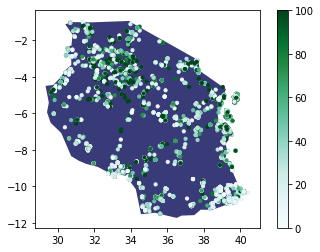

In [35]:
## Plot with full survey dataset
fig, ax = plt.subplots(1, 1)
tan.plot(ax=ax, cmap='tab20b')
geo_df.plot(ax=ax, column='cons2', marker='o', markersize=10, cmap='BuGn', legend = True, legend_kwds={'loc': 'lower right'}, vmin=0, vmax=100)
#ax.set_xbound(lower=27, upper=44)

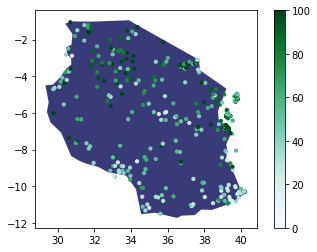

In [36]:
## Plot with filtered (clustered) survey dataset
#geo_df_filtered.plot(ax=tan.plot(cmap='tab20b', figsize=(10, 6)),
#             marker='o', markersize=15, cmap='BuGn', legend = True, legend_kwds={'loc': 'lower right'});
fig, ax = plt.subplots(1, 1)
tan.plot(ax=ax, cmap='tab20b')
geo_df_filtered.plot(column='cons2', ax=ax, marker='o', markersize=10, cmap='BuGn', legend = True, legend_kwds={'loc': 'lower right'}, vmin=0, vmax=100)

In [37]:
geo_df_filtered.head()

hhid,lat_dd_mod_x,lon_dd_mod_x,count,lat_dd_mod_y,lon_dd_mod_y,cons2,geometry
id,,,,,,,
0,-11.497012,35.607626,13,-11.497012,35.607626,42.264669,POINT (35.6076255042 -11.4970123249)
2,-11.315454,34.786297,9,-11.315454,34.786297,33.312532,POINT (34.7862970999 -11.315454126)
6,-11.170319,34.996472,12,-11.170319,34.996472,23.262399,POINT (34.9964716241 -11.1703191963)
10,-11.108790,34.642166,9,-11.108790,34.642166,48.164958,POINT (34.6421658288 -11.1087903236)
12,-11.072451,37.319251,11,-11.072451,37.319251,24.731698,POINT (37.3192514844 -11.0724511372)


In [38]:
geo_df_filtered.describe()

hhid,lat_dd_mod_x,lon_dd_mod_x,count,lat_dd_mod_y,lon_dd_mod_y,cons2
count,409.000000,409.000000,409.000000,409.000000,409.000000,409.000000
mean,-6.301558,36.647170,9.161369,-6.301558,36.647170,83.071258
std,2.509866,2.980400,2.479005,2.509866,2.980400,73.907117
min,-11.497012,29.766474,3.000000,-11.497012,29.766474,14.126551
25%,-7.744347,33.960013,8.000000,-7.744347,33.960013,44.666421
50%,-6.296043,37.645690,9.000000,-6.296043,37.645690,64.070809
75%,-4.389721,39.244390,10.000000,-4.389721,39.244390,97.150325
max,-1.058783,40.223984,20.000000,-1.058783,40.223984,843.921075


In [39]:
import rasterio

In [40]:
satfile_DMSP = '/Users/sumithra/DSV/MeDESTO/geohackweek2019/satdata/DMSP_TimeSeries.tif'

Text(0, 0.5, 'Row #')

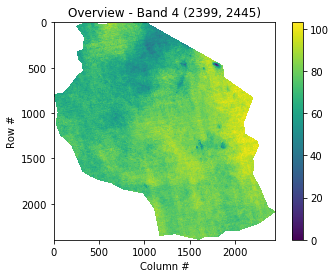

In [41]:
# The grid of raster values can be accessed as a numpy array and plotted:
with rasterio.open(satfile_DMSP) as src:
   #oviews = src.overviews(1) # list of overviews from biggest to smallest
   #oview = oviews[-1] # let's look at the smallest thumbnail
   #print('Decimation factor= {}'.format(oview))
   # NOTE this is using a 'decimated read' (http://rasterio.readthedocs.io/en/latest/topics/resampling.html)
   dmsp_tanzania = src.read(1)

plt.imshow(dmsp_tanzania)
plt.colorbar()
plt.title('Overview - Band 4 {}'.format(dmsp_tanzania.shape))
plt.xlabel('Column #')
plt.ylabel('Row #')

In [42]:
satfile_VIIRS = '/Users/sumithra/DSV/MeDESTO/geohackweek2019/satdata/VIIRS.tif'

{'driver': 'GTiff', 'dtype': 'float64', 'nodata': None, 'width': 2445, 'height': 2399, 'count': 1, 'crs': CRS.from_epsg(4326), 'transform': Affine(0.004491576420597608, 0.0, 29.338977179343573,
       0.0, -0.004491576420597608, -0.9477226247460953), 'blockxsize': 256, 'blockysize': 256, 'tiled': True, 'compress': 'lzw', 'interleave': 'band'}


Text(0, 0.5, 'Row #')

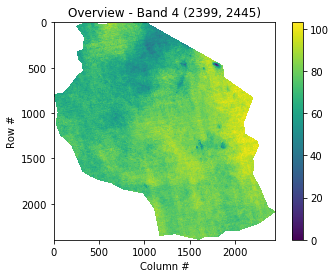

In [43]:
# The grid of raster values can be accessed as a numpy array and plotted:
with rasterio.open(satfile_DMSP) as src:
    print(src.profile)
   #oviews = src.overviews(1) # list of overviews from biggest to smallest
   #oview = oviews[-1] # let's look at the smallest thumbnail
   #print('Decimation factor= {}'.format(oview))
   # NOTE this is using a 'decimated read' (http://rasterio.readthedocs.io/en/latest/topics/resampling.html)
    viir_tanzania = src.read(1)

plt.imshow(viir_tanzania)
plt.colorbar()
plt.title('Overview - Band 4 {}'.format(dmsp_tanzania.shape))
plt.xlabel('Column #')
plt.ylabel('Row #')

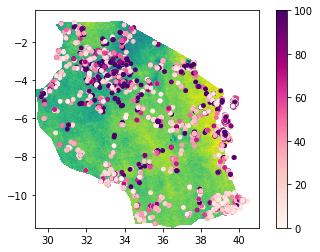

In [44]:
from rasterio.plot import show

fig, ax = plt.subplots()
with rasterio.open(satfile_DMSP) as src:
    show(src, ax=ax)
geo_df.plot(ax=ax, column='cons2', marker='o', vmin=0, vmax=100, markersize=15, cmap='RdPu', legend=True, legend_kwds={'loc': 'lower right'})
#geo_df_filtered.plot(ax=ax, marker='o', markersize=15, cmap='BuGn', legend=True, legend_kwds={'loc': 'lower right'})

In [45]:
cities = {'city':['Dodoma', 'Dar es Salaam'], 'lat': [-6.1630, -6.7924], 'lon': [35.7516, 39.2083]}
cities_df = pd.DataFrame(cities)

In [46]:
geometry_cities = [shapely.geometry.Point(xy) for xy in zip(cities_df['lon'], cities_df['lat'])]
city_df = gpd.GeoDataFrame(cities, geometry=geometry_cities)
city_df.crs = {'init' :'epsg:4326'}

/anaconda3/envs/sumithra-test/lib/python3.6/site-packages/geopandas/plotting.py:404: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  "'color'.", UserWarning)


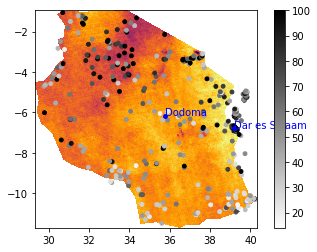

In [47]:
## holoviz - for interactive exploration
from rasterio.plot import show
#from rasterio.enums import ColorInterp


fig, ax = plt.subplots()
with rasterio.open(satfile_DMSP) as src:
    show(src, ax=ax, cmap='inferno')
geo_df_filtered.plot(ax=ax, column='cons2', marker='o', vmin=14, vmax=100, markersize=15, cmap='binary', legend=True, legend_kwds={'loc': 'lower right'})
city_df.plot(ax=ax, column='city', marker='o', markersize=15, color='Blue', legend=True)
#for i, txt in enumerate(zip(city_df['city'])):
for index, row in city_df.iterrows():
    ax.annotate(row['city'], (row['lon'], row['lat']), color='Blue')

In [48]:
geo_df_filtered.describe()

hhid,lat_dd_mod_x,lon_dd_mod_x,count,lat_dd_mod_y,lon_dd_mod_y,cons2
count,409.000000,409.000000,409.000000,409.000000,409.000000,409.000000
mean,-6.301558,36.647170,9.161369,-6.301558,36.647170,83.071258
std,2.509866,2.980400,2.479005,2.509866,2.980400,73.907117
min,-11.497012,29.766474,3.000000,-11.497012,29.766474,14.126551
25%,-7.744347,33.960013,8.000000,-7.744347,33.960013,44.666421
50%,-6.296043,37.645690,9.000000,-6.296043,37.645690,64.070809
75%,-4.389721,39.244390,10.000000,-4.389721,39.244390,97.150325
max,-1.058783,40.223984,20.000000,-1.058783,40.223984,843.921075


In [49]:
geo_df.describe()

,expmR,adulteq,cons,cons2,lat_dd_mod,lon_dd_mod
count,4.862000e+03,4862.000000,4.862000e+03,4862.000000,4862.000000,4862.000000
mean,4.087372e+06,4.140000,5.764781e+04,81.661779,-6.124882,36.321637
std,3.729201e+06,2.550232,1.034273e+05,146.511329,2.596510,3.069027
min,1.375010e+05,0.720000,3.315093e+02,0.469604,-11.497012,29.611354
25%,1.830167e+06,2.280000,1.332598e+04,18.877096,-7.640233,33.490770
50%,3.049115e+06,3.640000,2.914665e+04,41.288077,-6.167528,37.135584
75%,4.922050e+06,5.440000,6.514883e+04,92.287463,-4.065404,39.232132
max,4.655255e+07,39.800000,3.457857e+06,4898.274278,-0.998074,40.421223


In [50]:
world.head()

,pop_est,continent,name,iso_a3,gdp_md_est,geometry
0,920938,Oceania,Fiji,FJI,8374.0,"(POLYGON ((180 -16.06713266364245, 180 -16.555..."
1,53950935,Africa,Tanzania,TZA,150600.0,POLYGON ((33.90371119710453 -0.950000000000000...
2,603253,Africa,W. Sahara,ESH,906.5,POLYGON ((-8.665589565454809 27.65642588959236...
3,35623680,North America,Canada,CAN,1674000.0,"(POLYGON ((-122.84 49.00000000000011, -122.974..."
4,326625791,North America,United States of America,USA,18560000.0,"(POLYGON ((-122.84 49.00000000000011, -120 49...."


In [51]:
import cartopy

In [52]:
import cartopy.io.shapereader as shpreader

shpfilename = shpreader.natural_earth(resolution='110m',
                                      category='cultural',
                                      name='admin_0_countries')

/anaconda3/envs/sumithra-test/lib/python3.6/site-packages/cartopy/io/__init__.py:260: DownloadWarning: Downloading: http://naciscdn.org/naturalearth/110m/cultural/ne_110m_admin_0_countries.zip
  warnings.warn('Downloading: {}'.format(url), DownloadWarning)


In [53]:
reader = shpreader.Reader(shpfilename)
countries = reader.records()

In [54]:
countries

<generator object FionaReader.records at 0x127baf7d8>